In [3]:
import jax
jax.config.update("jax_enable_x64", True)

import chromatix.functional as cf
import jax.numpy as jnp
from chromatix.utils.fft import fft, ifft
from jax import Array
from jax.lax import scan
from jax.typing import ArrayLike
from sample import paper_sample
from tensor_tomo import outer, matvec, eps
import matplotlib.pyplot as plt


In [4]:
# Our input field is a plane wave
shape = (5 * 180, 5 * 180) # sample size
spacing = 0.065 # from paper
wavelength = 0.405 # from paper
nm = 1.33
polarisation = cf.linear(0) # x-polarised light

in_field = cf.plane_wave(shape, spacing, wavelength, 1.0, amplitude=polarisation, scalar=False, pupil=lambda f: cf.square_pupil(f, w = 400* spacing), power=100)
# Using gaussian beam
in_field = in_field.replace(u=in_field.u * jnp.sqrt(jnp.exp(-jnp.sum(in_field.grid**2, axis=0) / (2 * 4.0**2)))) # gaussian 
    

In [6]:
# Sample from the paper
sample = paper_sample()
print(f"Sample shape: {sample.shape}")

# Adding some padding for the propagation.
sample = cf.center_pad(sample, (0, 2 * 180, 2 * 180, 0, 0))

print(f"Padded sample shape: {sample.shape}")

Sample shape: (70, 180, 180, 3, 3)
Padded sample shape: (70, 900, 900, 3, 3)


In [9]:
print(f"Sample dtype: {sample.dtype}")
print(f"Field dtype: {in_field.u.dtype}")

Sample dtype: float64
Field dtype: complex128


In [10]:
def thick_polarised_sample_evanescent(field: cf.VectorField, potential: ArrayLike, nm: ArrayLike, dz: ArrayLike) -> cf.VectorField:
    def Q_op(u: Array) -> Array:
        # correct
        """Polarisation transfer operator"""
        return ifft(matvec(Q, fft(u)))
    
    def H_op(u: Array) -> Array:
        # correct
        """Vectorial scattering operator"""
        prefactor = -1j * dz / 2 * jnp.exp(1j * kz * dz) / kz
        return ifft(matvec(Q, prefactor * fft(u)))
    
    def P_op(u: Array) -> Array:
        # correct
        """Vectorial free space operator"""
        prefactor =  jnp.exp(1j * kz * dz)
        return ifft(matvec(Q, prefactor * fft(u)))

    def propagate_slice(u: Array, potential_slice: Array) -> tuple[Array, None]:
        scatter_field = matvec(potential_slice, Q_op(u))
        return P_op(u) + H_op(scatter_field), None

    # Preliminaries
    # We shift the k_grid so it aligns with unshifted fft output
    k_grid = jnp.fft.ifftshift(field.k_grid, axes=field.spatial_dims)

    # We use z yx ordering, and add the 2pi factor to chromatix kgrrid
    # We chop off evanescent waves
    # NOTE: understand why we need nm here
    km = 2 * jnp.pi * nm / field.spectrum
    k_grid = 2 * jnp.pi * k_grid
    kz = jnp.sqrt(km**2 - jnp.sum(k_grid**2, axis=0, dtype=jnp.complex128))
    k_grid =  jnp.concatenate([kz[None, ...], k_grid], axis=0)

    # Calculating PTFT
    Q = (-outer(k_grid / km, k_grid / km, in_axis=0) + jnp.eye(3)).squeeze(-3)

    # Running scan over sample
    u, _ = scan(propagate_slice, field.u, potential[..., None, :, :])
    return field.replace(u=u)

In [13]:
# Running the simulation
field = thick_polarised_sample_evanescent(in_field, sample, 1.33, 0.065)

# Making plotting a little easier
# ::-1 to invert y axis
amplitude = field.amplitude.squeeze()
amplitude = amplitude[::-1][360:-360, 360:-360]

phase = field.phase.squeeze()
phase = phase[::-1][360:-360, 360:-360]

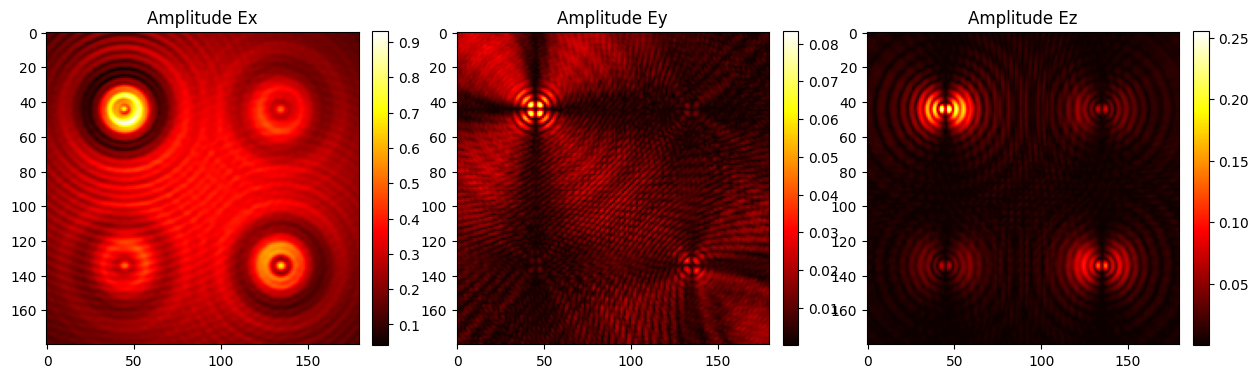

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Amplitude Ex")
plt.imshow(amplitude[..., 2], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Amplitude Ey")
plt.imshow(amplitude[..., 1], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Amplitude Ez")
plt.imshow(amplitude[..., 0], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

In [17]:
print(f"Output dtype: {amplitude.dtype}")

Output dtype: float64


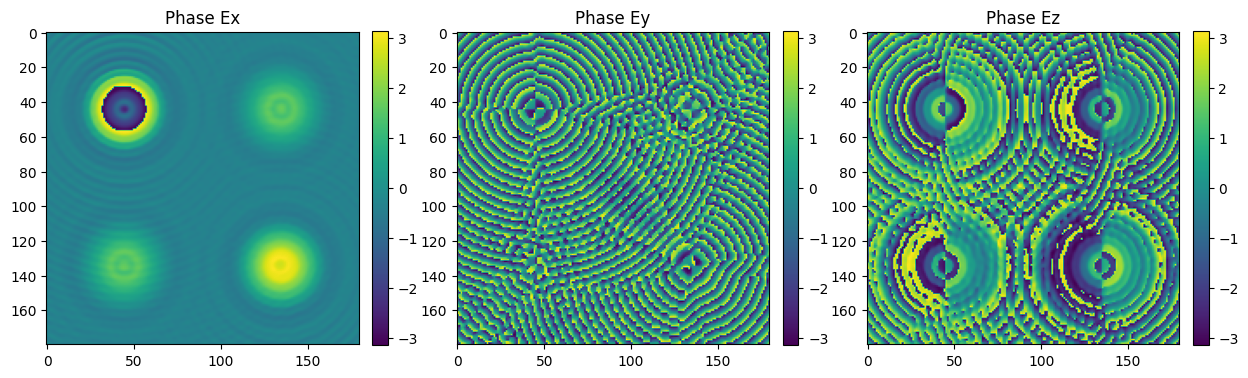

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Phase Ex")
plt.imshow(phase[..., 2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Phase Ey")
plt.imshow(phase[..., 1])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Phase Ez")
plt.imshow(phase[..., 0])
plt.colorbar(fraction=0.046, pad=0.04)

Seems like 64bit doesn't make a difference - great.